In [1]:
# Load API_key from .env file
from config_loader import ConfigLoader
config = ConfigLoader()

In [2]:
from typing import Annotated, Literal

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage

# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

In [3]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to research LangGraph for you. To get the most up-to-date and accurate information, I'll use the Tavily search engine to look this up. Let me do that for you now.", 'type': 'text'}, {'id': 'toolu_01ReiwvJbCYyCbJ9FJL4oNg7', 'input': {'query': 'LangGraph programming framework details and usage'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01ReiwvJbCYyCbJ9FJL4oNg7)
 Call ID: toolu_01ReiwvJbCYyCbJ9FJL4oNg7
  Args:
    query: LangGraph programming framework details and usage
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph's flexible f

In [6]:
#정상적으로 종료된 문답에 추가 휴먼메세지 입력
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

I apologize for the confusion, but it seems you've repeated your previous statement. Since we've already discussed building an autonomous agent with LangGraph, perhaps you'd like to move forward with more specific aspects of your project or explore some concrete ideas? 

To help guide our conversation in a productive direction, I could:

1. Suggest some specific autonomous agent project ideas that are well-suited for beginners using LangGraph.
2. Discuss the first steps you might take to set up your development environment for LangGraph.
3. Explore potential features or capabilities you might want to include in your autonomous agent.
4. Provide resources for learning more about the technical aspects of LangGraph implementation.

Which of these would be most hel

In [5]:
#graph.get_state(config).values["messages"]
#지금까지의 state 나열하고 돌아가고 싶은곳을 to_replay로 지정
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state


Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-----------------------------------------

In [7]:
#to_replay 확인차원 출력
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa8470-92ba-6d06-8006-e4cd27e1fb8c'}}


In [10]:
#12번 기존 출력한 message와 내용이 바뀐부분 파악 코드이해 완료!
# Tavliy search에서 불러온 url이 바뀌었음 (또한 to_replay.config 에 Checkpoint_id등이 있어서 내용 변경도 가능 
graph.get_state(config).values["messages"]

[HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", additional_kwargs={}, response_metadata={}, id='fc9ab8b8-2b05-4ccb-9ccd-8a0e1a3f6933'),
 AIMessage(content=[{'text': "Certainly! I'd be happy to research LangGraph for you. To get the most up-to-date and accurate information, I'll use the Tavily search engine to look this up. Let me do that for you now.", 'type': 'text'}, {'id': 'toolu_01ReiwvJbCYyCbJ9FJL4oNg7', 'input': {'query': 'LangGraph programming framework details and usage'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_016t4e3hB5qY1wdrbWTiEWGS', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 515, 'output_tokens': 116}}, id='run-a1ac3630-56c6-4d1d-b9a8-e6078d368920-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph programming framework details and usage'}, 'id': 'toolu_01Re

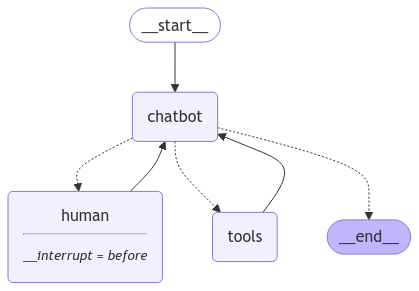

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass